**Load Basic Modules**

In [48]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

** Load data into pandas dataframe**

In [2]:
hepatitis_data = pd.read_csv("dataset_55_hepatitis.csv")

**Prediction algorithm**  

One of the main decisions to make when performing machine learning is choosing the appropriate algorithm that fits the current problem we are dealing with.
**Supervised learning** refers to the task of inferring a function from a labeled training dataset. We fit the model to the labeled training set with the main goal of finding the optimal parameters that will predict unknown labels of new examples included in the test dataset. There are two main types of supervised learning: regression, in which we want to predict a label that is a real number, and classification, in which we want to predict a categorical label.
In our case, we have a labeled dataset and we want to use a classification algorithm to find the label in the categorical values: 0 and 1.

We can find many classification supervised learning algorithms, some simple but efficient, such as linear classifier or logistic regression, and another ones more complex but powerful such as decision trees and k-means.  
In this case, we will choose **Random Forest** algorithm. Random forest is one of the most used machine learning algorithm due to the fact that it is very simple, flexible and easy to use but produces reliable results.
So we will load the packages from scikit-learn that we need to perform Random Forest and also to evaluate afterwards the model:

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import precision_recall_curve, confusion_matrix

from sklearn.preprocessing import Imputer

In [4]:
replacements = {'no': 0,
               'yes': 1,
               'DIE': 0,
               'LIVE': 1,
               '?': np.nan,
               'female': 0,
               'male': 1}

hepatitis_data.replace(replacements, inplace = True)
hepatitis_data = hepatitis_data.astype(float)

In the EDA, we dropped all `NaN` values. Here, we need to evaluate what is the best method to handle them.  
There are several ways to deal with missing data but none of them is perfect. The first step is to understand why data went missing. In our case, we can guess that the values missing in the categorical variables could be due to the absence of the feature that instead of being imputed as 'no' was left blank or that it was not tested. Also, missing values in continuous variables could be explained by the lack of biochemical studies performed in that particular patient or because the parameters were within normal range and it was not written down.  

In both cases, we could be in the presence of **Missing at Random** value (The fact that the value is missing has nothing to do with the hypothetical value) or **Missing not at Random** value (The missing value depends on the hypothetical value). If it was the first one, we could drop the `NaN` value safely, while in the last case it would not be safe to drop it because this missing value tell us something about the hypothetical value. So we will then impute the values of the missing value once we are about to train our model.

In [5]:
hepatitis_data.isnull().sum()

AGE                 0
SEX                 0
STEROID             1
ANTIVIRALS          0
FATIGUE             1
MALAISE             1
ANOREXIA            1
LIVER_BIG          10
LIVER_FIRM         11
SPLEEN_PALPABLE     5
SPIDERS             5
ASCITES             5
VARICES             5
BILIRUBIN           6
ALK_PHOSPHATE      29
SGOT                4
ALBUMIN            16
PROTIME            67
HISTOLOGY           0
Class               0
dtype: int64

**Training and Test datasets**

In order to train and test our model, we need to split our dataset into to subdatasets, the training and the test dataset. The model will learn from the training dataset to generalize to other data; the test dataset will be used to "test" what the model learnt in the training and fitting step. 
It is common to use the rule of 80%-20% to split the original dataset. It is important to use a reliable method to split the dataset to avoid data leakage; this is the presence in the test set of examples that were also in the training set. 
First, we will assign all the columns except our dependant variable ("Class") to the variable X and the column "Class" to the variable Y.
And then we will `train_test_split` from the scikit-learn library to split them into X_train, X_test, Y_train and Y_test. It is important to add `random_state` because this will allow us to have the same results every time we run the code. 

In [6]:
x = hepatitis_data.iloc[:, hepatitis_data.columns != 'Class']
y = hepatitis_data.iloc[:, hepatitis_data.columns == 'Class']

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, 
                                                    random_state = 42)

** Training Random Forest **

It is very easy now to impute missing values (using Imputer), create and train the basic random forest model using the package Scikit-learn.
We will start by apply .ravel() to the Y_train and Y_test to flatten our array as not doing so will rise warnings from our model. 

In [8]:
Y_train = Y_train.values.ravel()
Y_test = Y_test.values.ravel()

Then, we will impute our missing values using the function `Imputer` and the strategy `most_frequent` that will replace the missing values for the most frequent value in the column (axis = 0). It is worthy to notice that doing so can introduce errors and bias, but of course as we state before there is no perfect way to handle missing data.

In [9]:
imp = Imputer(missing_values = 'NaN', strategy = "most_frequent", axis = 0)
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)

fit_random_forest = RandomForestClassifier(random_state = 42)

fit_random_forest.fit(X_train_imp, Y_train);


Our basic model has now been trained and has learnt the relationship between our independent variables and the target variable. Now, we can check how good our model is by making predictions on the test set. We can then compare the prediction with our known labels.

We will again impute the missing values in our test set and use the function `predict` and the metrics `accuracy_score` to evaluate the performance of our model.

In [10]:
X_test_imp = imp.transform(X_test)

y_predicted = fit_random_forest.predict(X_test_imp)

In [11]:
accuracy = accuracy_score(Y_test, y_predicted)*100
print(round(accuracy, 2), '%')

74.19 %


As we can observe above, our basic model has an accuracy of 74.19% which tell us that it has to be further improved. 

** Hyperparameters tuning** 

There are several ways to improve our model: gather more data, tune the hyperparameters of the model or choose other models. We will choose the second one, we will now tune the hyperparameters of our random forest classifier.

Model parameters are normally learned during training; however hyperparameters must be set manually before training. In the case of random forest, hyperparameters include:

* n_estimators: number of trees in the forest
* max_features: maximum number of features in each tree
* max_depth: maximum splits for all trees
* bootstrap: whether to implement bootstrap or not to build trees
* criterion: assess stopping criteria for decision trees

Of course, when we implement basic random forest, Scikit-learn implements a set of default hyperparameters, but we are not sure if those parameters are the optimal for our particular problem. 

In this point is when we need to considered two concepts: underfitting and overfitting. *Underfitting* occurs when the model is too simple and it doesn't fit the data well: it has low variance but high bias. On the other hand, *overfitting* occurs when the model adjust too well to the training set and performs poorly in new examples.
If we tune the hyperparameters in the training dataset, we would then be prone to overfit our random forest classifier. So instead, we will go back to what was mentioned before: the *cross validation*.  
We will use **K-fold cross validation** method to tune the hyperparameters: we will perform many iterations on the K-subset cross validation but using different model settings each time. Afterwards, we compare all models and select the best one; then, we will train the best model in the full training set and evaluate it on the testing set. We will take advantage of *GridSearchCV* package in Scikit-learn to perform this task.

We will determine the parameters and values that we want to optimize and then we will performed the GridSearchCV:

In [31]:
parameters_optimize = {
                      'max_features': ['auto', 'sqrt', 'log2', None], 
                      'max_depth': [2,3, 4],
                      'criterion': ['gini', 'entropy'],
                      'bootstrap': [True, False],
                      'n_estimators': [2, 5, 10, 15, 20]
                      }

In [40]:
random_forest_hyp = RandomForestClassifier()

random_forest_search = GridSearchCV(random_forest_hyp,
                                   cv = 20,
                                   param_grid = parameters_optimize,
                                   n_jobs = 3)
random_forest_search.fit(X_train_imp, Y_train);

In [41]:
print('The best parameteres after GridSearchCV', random_forest_search.best_params_)


The best parameteres after GridSearchCV {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 5}


Now we set our model with the best parameters given by the GridSearchCV.

In [42]:
random_forest_hyp.set_params(bootstrap = True, 
                            criterion = 'gini',
                            max_depth = 4,
                            max_features = 'sqrt',
                            n_estimators = 5);

In [43]:
random_forest_hyp.fit(X_train_imp, Y_train);

In [44]:
y_predicted_grid = random_forest_hyp.predict(X_test_imp)

In [47]:
accuracy_grid = accuracy_score(Y_test, y_predicted_grid)*100
print(round(accuracy_grid, 2), '%')

77.42 %


As we can see above our GridSearchCV improve our accuracy from 74 to 77%. Even though that it's not a great improvement, it has been reported that with this dataset other reports reach only an accuracy of 80%. So considering this and the fact that the dataset has many missing data and it's not big (only 155 samples) we can go on and analyse other model metrics.

**Test set metrics**  

Now that we have optimized our hyperparameters, we will proceed to evaluate our model. First of all, we will create a confusion matrix that will tell us the True Negative, False positive, False negative and True Positive values according to our predicted values and plot it using seaborn heatmap:

True Negative (TN)  |  False positive (FP)   
= = = = = = = = = = = = = = = = = = = = =       
False negative (FN) | True positive (TP)  


<IPython.core.display.Javascript object>


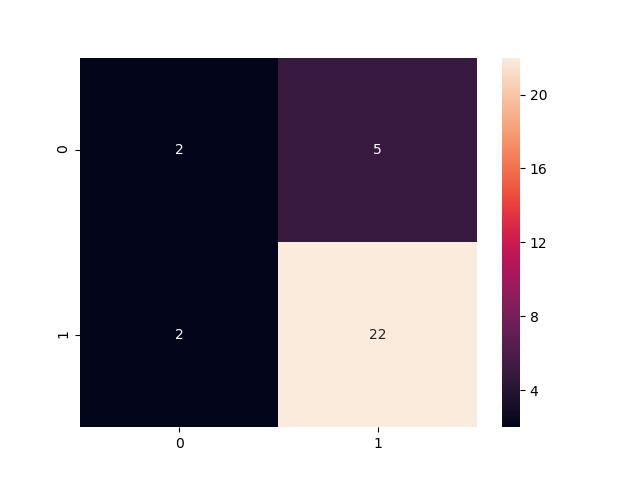

In [87]:
plt.figure()
random_confusion = confusion_matrix(Y_test, y_predicted_grid)
sns.heatmap(random_confusion, annot = True);

Analysing the confusion matrix, we can expect that our model shows a higher recall (TP/TP+FN) than precision (TP/TP+FP) but both parameters will be higher than the accuracy(TP+TN)/Total. These three parameters can be taken into consideration according to what we consider our model needs to solve. We will come back to these afterwards.

We can further investigate the False positive rates and true positive rates using ROC Curve and calculating the area under the curve that it is also a metric of the prediction power of our model (if the value is closer to 1 means that our model does a good job in differentiating a random sample into the two classes).


In [90]:
fpr, tpr, _= roc_curve(Y_test, y_predicted_grid)

In [81]:
auc_random_grid = auc(fpr, tpr)
print(auc_random_grid)

0.60119047619


<IPython.core.display.Javascript object>


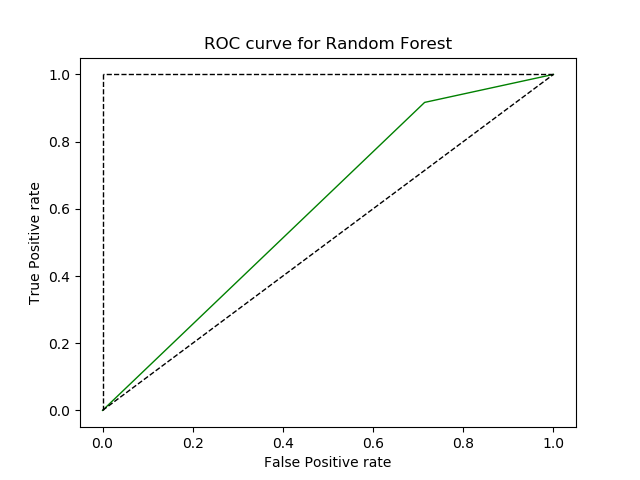

In [86]:
plt.figure()
plt.plot(fpr, tpr, color ='Green', linewidth = 1)
plt.title('ROC curve for Random Forest')
plt.plot([0,1], [0,1], 'k--', lw = 1)
plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate');

From the ROC curve, we learned that our model does not do a good job in distinguishing between both classes as the auc is 0.60. We could improve this issue by collecting and adding more data to the model.

Last, we can analyse the precision-recall curve:

<IPython.core.display.Javascript object>


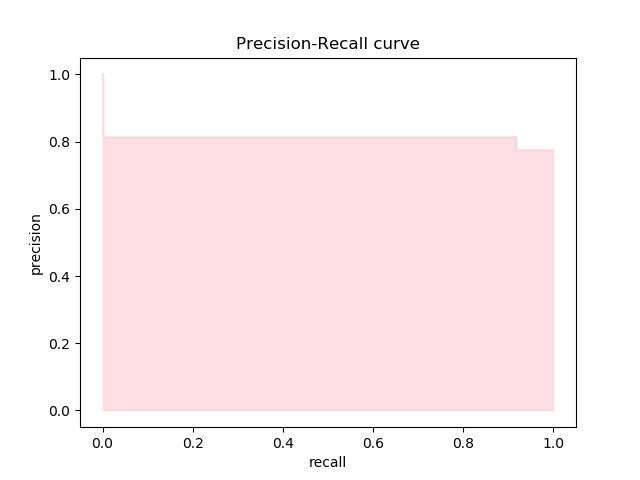

In [97]:
precision, recall, _ = precision_recall_curve(Y_test, y_predicted_grid)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');


We can observe that the precision-recall relationship is quite constant for the different values, indicating that our model has a good precision and recall. This is due to the fact that the True Positive values are quite high compared to the true negative, false positive and false negative. It is important to remember that because of the formula of recall and precision, when one is high the other one is low pushing us to find a balance where both are high enough for our model.